Create the environment.

In [1]:
import gym
import gym_continuous_maze

env = gym.make("ContinuousMaze-v0")

Choose the device.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [3]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer


buffer = ReplayBuffer(10000, env.observation_space, env.action_space, device=device)

for episode in range(100):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

Build the model.

In [4]:
from go_explore.vae import Linear_VQ_VAE

vae = Linear_VQ_VAE(2, embedding_dim=1, num_embeddings=20).to(device)

/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


## Test the VAE

Sample a batch of observations.

In [5]:
input = buffer.sample(10).observations

Build the reconstruction.

In [6]:
recons, vq_loss, perplexity = vae(input)

Visualize the result.

In [7]:
input, recons

(tensor([[-2.4396, -1.3655],
         [-0.5882, -1.2030],
         [-2.9576, -1.3150],
         [-2.8197, -1.9785],
         [-0.3236,  0.7054],
         [-1.5119, -0.5108],
         [-1.3692,  1.0929],
         [ 0.3785, -1.0789],
         [-1.3804, -0.8298],
         [ 1.7906,  2.6254]], device='cuda:0'),
 tensor([[0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6397, 0.8235],
         [0.6487, 0.8471]], device='cuda:0', grad_fn=<AddmmBackward0>))

## Train the model

Create a loss function.

In [8]:
import torch.nn.functional as F
from typing import Tuple
from torch import Tensor


def loss_func(inputs: Tensor, recons: Tensor, vq_loss: Tensor) -> Tuple[Tensor, Tensor]:
    # Reconstruction loss
    recons_loss = F.mse_loss(inputs, recons)  # / data_variance

    # Total loss
    loss = recons_loss + 0.1 * vq_loss

    return loss, recons_loss

Test the loss function.

In [9]:
loss_func(input, recons, vq_loss)

(tensor(4.2052, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(4.1825, device='cuda:0', grad_fn=<MseLossBackward0>))

Create optimizer.

In [10]:
from torch import optim

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [11]:
perplexities = []
for epoch in range(10000):
    # Sample
    input = buffer.sample(128).observations

    # Compute the output image
    vae.train()
    recons, vq_loss, perplexity = vae(input)

    # Compute the loss
    loss, recons_loss = loss_func(input, recons, vq_loss)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    perplexities.append(perplexity.item())

    if epoch % 1000 == 0:
        print(
            "epoch: {:5d}\tloss: {:.5f}\trecons loss: {:.5f}\tvq loss: {:.5f}".format(
                epoch, loss.item(), recons_loss.item(), vq_loss.item()
            ),
        )
        vae.eval()

epoch:     0	loss: 4.57812	recons loss: 4.55433	vq loss: 0.23786
epoch:  1000	loss: 11.17864	recons loss: 2.76774	vq loss: 84.10896
epoch:  2000	loss: 13.00703	recons loss: 1.82743	vq loss: 111.79592
epoch:  3000	loss: 6.11501	recons loss: 2.19555	vq loss: 39.19460
epoch:  4000	loss: 2.99226	recons loss: 1.88988	vq loss: 11.02380
epoch:  5000	loss: 2.41692	recons loss: 1.82584	vq loss: 5.91079
epoch:  6000	loss: 1.22397	recons loss: 0.95564	vq loss: 2.68332
epoch:  7000	loss: 2.54456	recons loss: 0.88109	vq loss: 16.63468
epoch:  8000	loss: 1.63494	recons loss: 0.61345	vq loss: 10.21491
epoch:  9000	loss: 1.08327	recons loss: 0.50882	vq loss: 5.74450


In [12]:
input = buffer.sample(10).observations
recons, vq_loss, perplexity = vae(input)
F.mse_loss(input, recons)

tensor(0.2598, device='cuda:0', grad_fn=<MseLossBackward0>)

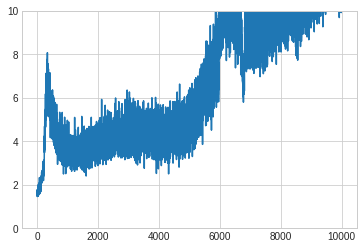

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
import numpy as np

fig = plt.figure()
ax = plt.axes()
ax.set_ylim(0, 10)

ax.plot(perplexities);

In [14]:
from go_explore.cells import get_param_score

input = buffer.sample(512).observations

# Compute the output image
vae.eval()
quantized = vae.get_quantized(input)
get_param_score(quantized)

0.6208777574309989

In [15]:
input = buffer.sample(10).observations
input, vae(input)[0]

(tensor([[ 0.6394,  2.4636],
         [-3.4143,  3.1747],
         [-3.0605, -0.3981],
         [ 1.7350,  0.5026],
         [-0.3900, -0.5075],
         [ 1.8079, -0.7320],
         [ 0.8254, -1.1248],
         [ 1.6834,  3.1079],
         [-1.0810, -1.2774],
         [-2.2364,  0.8462]], device='cuda:0'),
 tensor([[ 1.0690,  2.8953],
         [-3.7387,  3.9577],
         [-3.4173, -0.9726],
         [ 0.8882, -0.6095],
         [-0.0682, -0.7583],
         [ 0.8882, -0.6095],
         [ 0.8882, -0.6095],
         [ 1.0774,  3.5569],
         [-0.7353, -0.7118],
         [-2.3721,  0.6804]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [16]:
vae.encode(input)

tensor([[ 4.6575, -6.2800],
        [-9.6740, -7.2826],
        [-7.2227,  5.6874],
        [ 4.8805,  1.9901],
        [ 2.5006,  2.8642],
        [ 4.8813,  2.0201],
        [ 4.8813,  2.0201],
        [ 4.6156, -7.8347],
        [ 0.1676,  3.6915],
        [-4.6208,  0.7368]], device='cuda:0', grad_fn=<AddmmBackward0>)